In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession\
.builder\
.config("spark.submit.deployMode", "client")\
.config("spark.executor.instances", "1")\
.config("spark.executor.memory", "1g")\
.config("spark.driver.memory", "1g")\
.config("spark.executor.memoryOverhead", "1g")\
.appName("transporte")\
.master("spark://sparkmaster:7077")\
.getOrCreate()

spark.sparkContext._conf.getAll()

22/08/04 19:03:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


[('spark.app.startTime', '1659639801903'),
 ('spark.driver.host', 'sparkmaster'),
 ('spark.app.id', 'app-20220804190323-0000'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'transporte'),
 ('spark.driver.memory', '1g'),
 ('spark.master', 'spark://sparkmaster:7077'),
 ('spark.executor.memory', '1g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.instances', '1'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '41535'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.sql.warehouse.dir', 'file:/home/userpython/spark-warehouse'),
 ('spark.executor.memoryOverhead', '1g')]

In [ ]:
#Se crea el dataframe
data = spark.read.csv('hdfs://namenode:9000/cursoFAI/transporte.csv', header=True,  inferSchema=True)

In [ ]:
#Se realiza limpieza y preparacion de datos
#Se requieren datos numericos para la clasificacion
from pyspark.sql import functions as f
from pyspark.sql.functions import regexp_replace
import datetime
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, StringType

data2 = data.withColumn("TIPO_TRANSPORTE", data["TIPO_TRANSPORTE"].cast(StringType ()))
df = data2

df = df.where(df.TIPO_TRANSPORTE!="TOTAL") #se quitan todas las filas con valor TOTAL en tipo_transporte
df = df.fillna("E", subset=['GENERO']) #reemplazo los generos none por E para listarlos
df = df.fillna("SINMOTIVO", subset=['MOTIVO_ATSF']) #reemplazo los motivos_atsf none por sinmotivo para listarlos

#Hacemos numerico el AMBA
df = df.withColumn('AMBA', regexp_replace('AMBA', 'SI', '1'))#el regex_replace reemplaza valores de una columna
df = df.withColumn('AMBA', regexp_replace('AMBA', 'NO', '0'))
df = df.withColumn("AMBA", df["AMBA"].cast(IntegerType ()))#se castea el resultado a integer

#Hacemos numerico el GENERO
df = df.withColumn('GENERO', regexp_replace('GENERO', 'E', '0'))
df = df.withColumn('GENERO', regexp_replace('GENERO', 'F', '1'))
df = df.withColumn('GENERO', regexp_replace('GENERO', 'M', '2'))
df = df.withColumn("GENERO", df["GENERO"].cast(IntegerType ()))

#Hacemos numerico el TIPO_TRANSPORTE
df = df.withColumn('TIPO_TRANSPORTE', regexp_replace('TIPO_TRANSPORTE', 'COLECTIVO', '1'))
df = df.withColumn('TIPO_TRANSPORTE', regexp_replace('TIPO_TRANSPORTE', 'LANCHA', '2'))
df = df.withColumn('TIPO_TRANSPORTE', regexp_replace('TIPO_TRANSPORTE', 'SUBTE', '3'))
df = df.withColumn('TIPO_TRANSPORTE', regexp_replace('TIPO_TRANSPORTE', 'TREN', '4'))
df = df.withColumn("TIPO_TRANSPORTE", df["TIPO_TRANSPORTE"].cast(IntegerType ()))

#Hacemos numerico el MOTIVO_ATSF
df = df.withColumn('MOTIVO_ATSF', regexp_replace('MOTIVO_ATSF', 'SINMOTIVO', '0'))
df = df.withColumn('MOTIVO_ATSF', regexp_replace('MOTIVO_ATSF', 'AUH', '1'))
df = df.withColumn('MOTIVO_ATSF', regexp_replace('MOTIVO_ATSF', 'JUBILACION', '2'))
df = df.withColumn('MOTIVO_ATSF', regexp_replace('MOTIVO_ATSF', 'MONOTRIBUTO SOCIAL', '3'))
df = df.withColumn('MOTIVO_ATSF', regexp_replace('MOTIVO_ATSF', 'PENSION', '4'))
df = df.withColumn('MOTIVO_ATSF', regexp_replace('MOTIVO_ATSF', 'PERSONAL DEL TRABAJO DOMÉSTICO', '5'))
df = df.withColumn('MOTIVO_ATSF', regexp_replace('MOTIVO_ATSF', 'PROGRESAR', '6'))
df = df.withColumn('MOTIVO_ATSF', regexp_replace('MOTIVO_ATSF', 'OTRO', '7'))
df = df.withColumn("MOTIVO_ATSF", df["MOTIVO_ATSF"].cast(IntegerType ()))

#Hacemos numerico el DATO_PRELIMINAR
df = df.withColumn('DATO_PRELIMINAR', regexp_replace('DATO_PRELIMINAR', 'SI', '1'))
df = df.withColumn('DATO_PRELIMINAR', regexp_replace('DATO_PRELIMINAR', 'NO', '0'))
df = df.withColumn("DATO_PRELIMINAR", df["DATO_PRELIMINAR"].cast(IntegerType ()))

split_col = F.split(df['DIA_TRANSPORTE'], '-')
df = df.withColumn('ANIO', split_col.getItem(0))
df = df.withColumn('MES', split_col.getItem(1))
df = df.withColumn('DIA', split_col.getItem(2))
df = df.withColumn("ANIO", df["ANIO"].cast(IntegerType ()))
df = df.withColumn("MES", df["MES"].cast(IntegerType ()))
df = df.withColumn("DIA", df["DIA"].cast(IntegerType ()))

df = df.drop('DIA_TRANSPORTE')

df_con_fechas = df
#Se requiere crear clases para la cantidad de tarjetas
#Agregamos clase a la cantidad de tarjetas

df = df.withColumn('CLASS', f.when(f.col('CANT_TRJ') < 163647, 1).otherwise(f.col('CANT_TRJ')))#MUY BAJO
df = df.withColumn('CLASS', f.when((f.col('CANT_TRJ') > 163646) & (f.col('CANT_TRJ') < 327294), 2).otherwise(f.col('CANT_TRJ')))#BAJO
df = df.withColumn('CLASS', f.when((f.col('CANT_TRJ') > 327293) & (f.col('CANT_TRJ') < 490941), 3).otherwise(f.col('CANT_TRJ')))#MEDIO BAJO
df = df.withColumn('CLASS', f.when((f.col('CANT_TRJ') > 490941) & (f.col('CANT_TRJ') < 654588), 4).otherwise(f.col('CANT_TRJ')))#MEDIO
df = df.withColumn('CLASS', f.when((f.col('CANT_TRJ') > 654587) & (f.col('CANT_TRJ') < 818235), 5).otherwise(f.col('CANT_TRJ')))#MEDIO ALTO
df = df.withColumn('CLASS', f.when((f.col('CANT_TRJ') > 818234) & (f.col('CANT_TRJ') < 981882), 6).otherwise(f.col('CANT_TRJ')))#ALTO
df = df.withColumn('CLASS', f.when(f.col('CANT_TRJ') > 981881, 7).otherwise(f.col('CANT_TRJ')))#MUY ALTO

df = df.withColumn('CLASS', f.when(f.col('CLASS') < 163647, 1).otherwise(f.col('CLASS')))#MUY BAJO
df = df.withColumn('CLASS', f.when((f.col('CLASS') > 163646) & (f.col('CLASS') < 327294), 2).otherwise(f.col('CLASS')))#BAJO
df = df.withColumn('CLASS', f.when((f.col('CLASS') > 327293) & (f.col('CLASS') < 490941), 3).otherwise(f.col('CLASS')))#MEDIO BAJO
df = df.withColumn('CLASS', f.when((f.col('CLASS') > 490941) & (f.col('CLASS') < 654588), 4).otherwise(f.col('CLASS')))#MEDIO
df = df.withColumn('CLASS', f.when((f.col('CLASS') > 654587) & (f.col('CLASS') < 818235), 5).otherwise(f.col('CLASS')))#MEDIO ALTO
df = df.withColumn('CLASS', f.when((f.col('CLASS') > 818234) & (f.col('CLASS') < 981882), 6).otherwise(f.col('CLASS')))#ALTO
df = df.withColumn('CLASS', f.when(f.col('CLASS') > 981881, 7).otherwise(f.col('CLASS')))#MUY ALTO
#df2.show()



In [ ]:
#Con esto podemos ver si la limpieza se hizo correctamente
import pandas as pd
df.show()
pdf_transporte_2 = df.toPandas()
print(pdf_transporte_2.describe())
print(pdf_transporte_2.info())
pdf_transporte_2.tail()
pdf_transporte_3=df.toPandas()

+----+-----------+------+---------------+--------+---------------+----+---+---+-----+
|AMBA|MOTIVO_ATSF|GENERO|TIPO_TRANSPORTE|CANT_TRJ|DATO_PRELIMINAR|ANIO|MES|DIA|CLASS|
+----+-----------+------+---------------+--------+---------------+----+---+---+-----+
|   0|          0|     0|              1|   33231|              0|2021|  1|  1|    1|
|   0|          0|     0|              2|       0|              0|2021|  1|  1|    1|
|   0|          0|     0|              3|       0|              0|2021|  1|  1|    1|
|   0|          0|     0|              4|       0|              0|2021|  1|  1|    1|
|   0|          0|     1|              1|   13693|              0|2021|  1|  1|    1|
|   0|          0|     1|              2|       2|              0|2021|  1|  1|    1|
|   0|          0|     1|              3|       0|              0|2021|  1|  1|    1|
|   0|          0|     1|              4|       0|              0|2021|  1|  1|    1|
|   0|          0|     2|              1|   12866|    

,AMBA,MOTIVO_ATSF,GENERO,TIPO_TRANSPORTE,CANT_TRJ,DATO_PRELIMINAR,ANIO,MES,DIA,CLASS
49635,1,6,1,4,4191,0,2021,12,31,1
49636,1,6,2,1,10173,0,2021,12,31,1
49637,1,6,2,2,0,0,2021,12,31,1
49638,1,6,2,3,593,0,2021,12,31,1
49639,1,6,2,4,1784,0,2021,12,31,1


In [ ]:
#EXPERIMENTOS:

In [ ]:
#Se importan las librerias necesarias
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.linear_model import LinearRegression
model=LinearRegression()
from pyspark.sql import functions as F
from sklearn import tree
from dtreeviz.trees import*
import graphviz

In [ ]:
# EXPERIMENTO 1 REGRESION:
x = pdf_transporte_2[['TIPO_TRANSPORTE']]
y = pdf_transporte_2['CANT_TRJ']

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2,random_state=1)

In [ ]:
print('numero de datos', len(x))
print('numero de datos para entrenamiendo del modelo', len(x_train))
print('numero de datos para probar el modelo', len(x_test))

numero de datos 49640
numero de datos para entrenamiendo del modelo 39712
numero de datos para probar el modelo 9928


In [ ]:
#entrenar el modelo
model.fit(x_train,y_train)

LinearRegression()

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
r2=model.score(x_test,y_test)
print('valor del coeficiente determiancion r2:',str(r2))


valor del coeficiente determiancion r2: 0.0700176988564396


In [ ]:
residual=y_test-y_pred
residual

34725    -32977.573327
14133    -32977.573327
530       -9750.035883
43327    129505.501560
45984    -51794.110770
             ...      
13649    -32977.573327
24884    -43516.110770
35976    579211.889230
46847      6264.501560
30145    -32977.573327
Name: CANT_TRJ, Length: 9928, dtype: float64

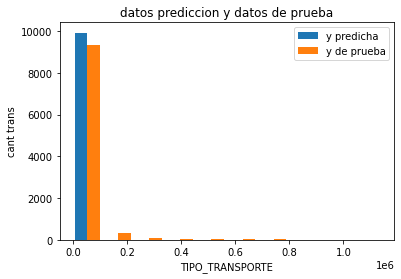

In [ ]:
plt.hist([y_pred, y_test])
plt.title('datos prediccion y datos de prueba')
plt.ylabel('cant trans')
plt.xlabel('TIPO_TRANSPORTE')
plt.legend(['y predicha','y de prueba'])
plt.show()

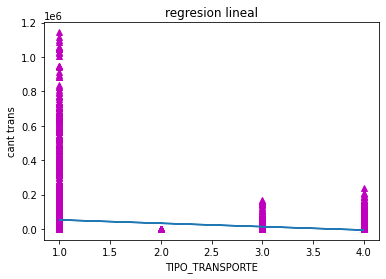

In [ ]:
#graficar resultados
plt.plot(x_test,y_test,'m^')
plt.plot(x_test, model.coef_*x_test+model.intercept_)
plt.title('regresion lineal')
plt.ylabel('cant trans')
plt.xlabel('TIPO_TRANSPORTE')
plt.show()


numero de datos 24820
numero de datos para entrenamiendo del modelo 19856
numero de datos para probar el modelo 4964
valor del coeficiente determiancion r2: -0.00021734677549312131


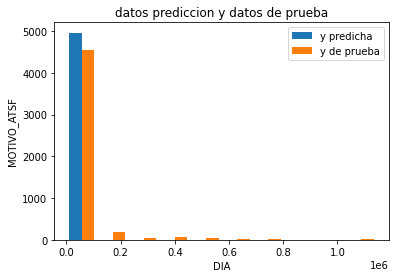

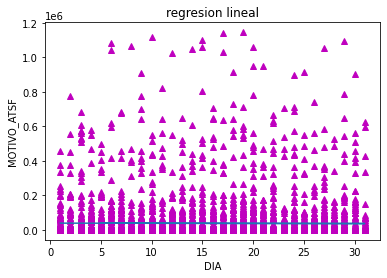

In [ ]:
#EXPERIMENTOS ADICIONALES REGRECION LINEAL, DEL DIA DEPENDE CANT_TRJ?
x = pdf_transporte_2[['DIA']]
y = pdf_transporte_2['CANT_TRJ']
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2,random_state=1)
print('numero de datos', len(x))
print('numero de datos para entrenamiendo del modelo', len(x_train))
print('numero de datos para probar el modelo', len(x_test))
#entrenar el modelo
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
r2=model.score(x_test,y_test)
print('valor del coeficiente determiancion r2:',str(r2))
residual=y_test-y_pred
residual

#graficar resultados
plt.hist([y_pred, y_test])
plt.title('datos prediccion y datos de prueba')
plt.ylabel('CANT_TRJ')
plt.xlabel('DIA')
plt.legend(['y predicha','y de prueba'])
plt.show()
plt.plot(x_test,y_test,'m^')
plt.plot(x_test, model.coef_*x_test+model.intercept_)
plt.title('regresion lineal')
plt.ylabel('CANT_TRJ')
plt.xlabel('DIA')
plt.show()






numero de datos 24820
numero de datos para entrenamiendo del modelo 19856
numero de datos para probar el modelo 4964
valor del coeficiente determiancion r2: 0.0038473390336517532


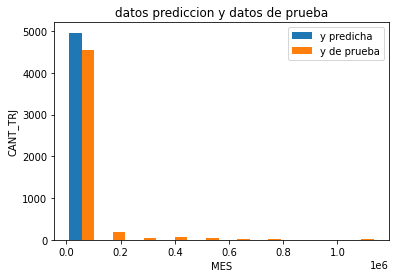

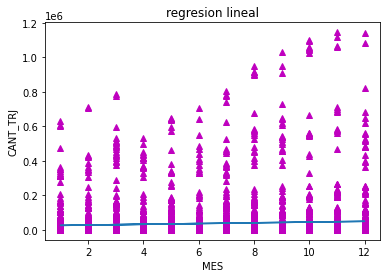

In [ ]:
#EXPERIMENTOS ADICIONALES REGRECION LINEAL, DEL MES DEPENDE CANT_TRJ?
x = pdf_transporte_2[['MES']]
y = pdf_transporte_2['CANT_TRJ']
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2,random_state=1)
print('numero de datos', len(x))
print('numero de datos para entrenamiendo del modelo', len(x_train))
print('numero de datos para probar el modelo', len(x_test))
#entrenar el modelo
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
r2=model.score(x_test,y_test)
print('valor del coeficiente determiancion r2:',str(r2))
residual=y_test-y_pred
residual

#graficar resultados

plt.hist([y_pred, y_test])
plt.title('datos prediccion y datos de prueba')
plt.ylabel('CANT_TRJ')
plt.xlabel('MES')
plt.legend(['y predicha','y de prueba'])
plt.show()
plt.plot(x_test,y_test,'m^')
plt.plot(x_test, model.coef_*x_test+model.intercept_)
plt.title('regresion lineal')
plt.ylabel('CANT_TRJ')
plt.xlabel('MES')
plt.show()






numero de datos 49640
numero de datos para entrenamiendo del modelo 39712
numero de datos para probar el modelo 9928
valor del coeficiente determiancion r2: 0.08270948952571011


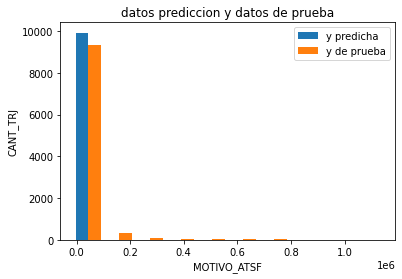

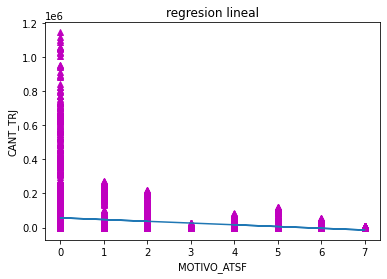

In [ ]:
#EXPERIMENTOS ADICIONALES REGRECION LINEAL, EL MOTIVE_ATSF DEPENDE CANT_TRJ?
x = pdf_transporte_2[['MOTIVO_ATSF']]
y = pdf_transporte_2['CANT_TRJ']
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2,random_state=1)
print('numero de datos', len(x))
print('numero de datos para entrenamiendo del modelo', len(x_train))
print('numero de datos para probar el modelo', len(x_test))
#entrenar el modelo
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
r2=model.score(x_test,y_test)
print('valor del coeficiente determiancion r2:',str(r2))
residual=y_test-y_pred
residual

#graficar resultados

plt.hist([y_pred, y_test])
plt.title('datos prediccion y datos de prueba')
plt.ylabel('CANT_TRJ')
plt.xlabel('MOTIVO_ATSF')
plt.legend(['y predicha','y de prueba'])
plt.show()
plt.plot(x_test,y_test,'m^')
plt.plot(x_test, model.coef_*x_test+model.intercept_)
plt.title('regresion lineal')
plt.ylabel('CANT_TRJ')
plt.xlabel('MOTIVO_ATSF')
plt.show()






numero de datos 49640
numero de datos para entrenamiendo del modelo 39712
numero de datos para probar el modelo 9928
valor del coeficiente determiancion r2: 0.0700176988564396


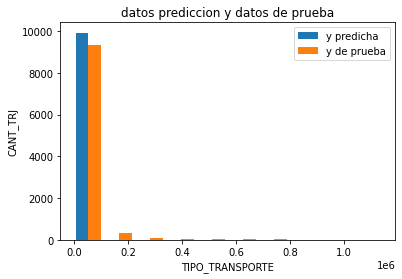

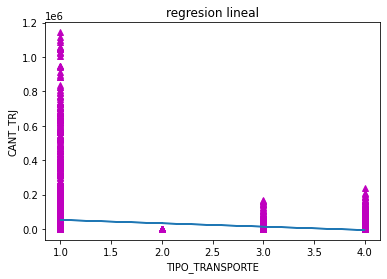

In [ ]:
#experimientos limitando las entradas a AMBA
#mascara booleana
df_mask=df_con_fechas['AMBA']==1
#dataset solo con AMBA
df = df[df_mask]

pdf_transporte_2 = df.toPandas()
print(pdf_transporte_2.describe())
print(pdf_transporte_2.info())
pdf_transporte_2.tail()

x = pdf_transporte_2[['TIPO_TRANSPORTE']]
y = pdf_transporte_2['CANT_TRJ']
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2,random_state=1)
print('numero de datos', len(x))
print('numero de datos para entrenamiendo del modelo', len(x_train))
print('numero de datos para probar el modelo', len(x_test))
#entrenar el modelo
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
r2=model.score(x_test,y_test)
print('valor del coeficiente determiancion r2:',str(r2))
residual=y_test-y_pred
residual

#graficar resultados

plt.hist([y_pred, y_test])
plt.title('datos prediccion y datos de prueba')
plt.ylabel('CANT_TRJ')
plt.xlabel('TIPO_TRANSPORTE')
plt.legend(['y predicha','y de prueba'])
plt.show()
plt.plot(x_test,y_test,'m^')
plt.plot(x_test, model.coef_*x_test+model.intercept_)
plt.title('regresion lineal')
plt.ylabel('CANT_TRJ')
plt.xlabel('TIPO_TRANSPORTE')
plt.show()

         AMBA  MOTIVO_ATSF       GENERO  TIPO_TRANSPORTE       CANT_TRJ  \
count  2920.0       2920.0  2920.000000      2920.000000    2920.000000   
mean      1.0          2.0     1.500000         2.500000   27882.430137   
std       0.0          0.0     0.500086         1.118225   47538.185021   
min       1.0          2.0     1.000000         1.000000       0.000000   
25%       1.0          2.0     1.000000         1.750000       0.000000   
50%       1.0          2.0     1.500000         2.500000    5847.000000   
75%       1.0          2.0     2.000000         3.250000   25256.000000   
max       1.0          2.0     2.000000         4.000000  230291.000000   

       DATO_PRELIMINAR    ANIO          MES          DIA        CLASS  
count           2920.0  2920.0  2920.000000  2920.000000  2920.000000  
mean               0.0  2021.0     6.526027    15.720548     1.031507  
std                0.0     0.0     3.448442     8.797754     0.174713  
min                0.0  2021.0     1

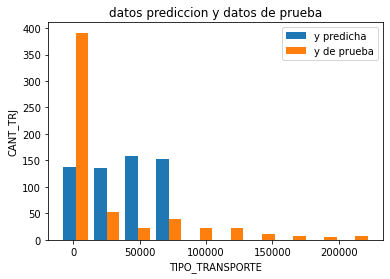

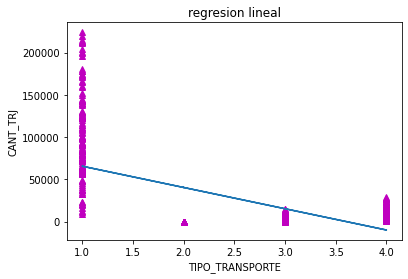

In [ ]:
#EXPERIMENTO LIMITAR ENTRADAS A  AMBA Y JUBILADOS 
#mascara booleana
df_mask=df_con_fechas['AMBA']==1
df = df[df_mask]
df_mask=df_con_fechas['MOTIVO_ATSF']==2

#dataset solo con los jubilidados y amba

df = df[df_mask]
pdf_transporte_2 = df.toPandas()
print(pdf_transporte_2.describe())
print(pdf_transporte_2.info())
pdf_transporte_2.tail()


#EXPERIMENTOS ADICIONALES REGRECION LINEAL EL CANT_TRJ DEPENDE DEL TIPO DE TRANSPORTE?
x = pdf_transporte_2[['TIPO_TRANSPORTE']]
y = pdf_transporte_2['CANT_TRJ']
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2,random_state=1)
print('numero de datos', len(x))
print('numero de datos para entrenamiendo del modelo', len(x_train))
print('numero de datos para probar el modelo', len(x_test))
#entrenar el modelo
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
r2=model.score(x_test,y_test)
print('valor del coeficiente determiancion r2:',str(r2))
residual=y_test-y_pred
residual

#graficar resultados

plt.hist([y_pred, y_test])
plt.title('datos prediccion y datos de prueba')
plt.ylabel('CANT_TRJ')
plt.xlabel('TIPO_TRANSPORTE')
plt.legend(['y predicha','y de prueba'])
plt.show()
plt.plot(x_test,y_test,'m^')
plt.plot(x_test, model.coef_*x_test+model.intercept_)
plt.title('regresion lineal')
plt.ylabel('CANT_TRJ')
plt.xlabel('TIPO_TRANSPORTE')
plt.show()

         AMBA  MOTIVO_ATSF       GENERO  TIPO_TRANSPORTE       CANT_TRJ  \
count  2920.0       2920.0  2920.000000      2920.000000    2920.000000   
mean      1.0          2.0     1.500000         2.500000   27882.430137   
std       0.0          0.0     0.500086         1.118225   47538.185021   
min       1.0          2.0     1.000000         1.000000       0.000000   
25%       1.0          2.0     1.000000         1.750000       0.000000   
50%       1.0          2.0     1.500000         2.500000    5847.000000   
75%       1.0          2.0     2.000000         3.250000   25256.000000   
max       1.0          2.0     2.000000         4.000000  230291.000000   

       DATO_PRELIMINAR    ANIO          MES          DIA        CLASS  
count           2920.0  2920.0  2920.000000  2920.000000  2920.000000  
mean               0.0  2021.0     6.526027    15.720548     1.031507  
std                0.0     0.0     3.448442     8.797754     0.174713  
min                0.0  2021.0     1

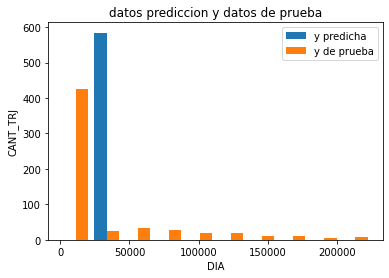

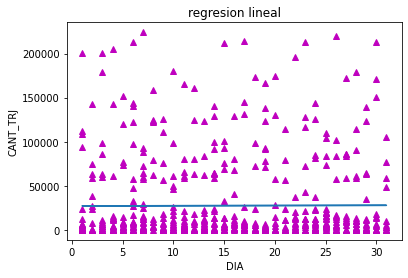

In [ ]:
#EXPERIMENTO LIMITAR A AMBA Y JUBILADOS
#mascara booleana
df_mask=df_con_fechas['AMBA']==1
df = df[df_mask]
df_mask=df_con_fechas['MOTIVO_ATSF']==2
#dataset solo con los jubilidados y de amba

df = df[df_mask]
pdf_transporte_2 = df.toPandas()
print(pdf_transporte_2.describe())
print(pdf_transporte_2.info())
pdf_transporte_2.tail()


#EXPERIMENTOS ADICIONALES REGRECION LINEAL EL CANT_TRJ DEPENDE DEL DIA?
x = pdf_transporte_2[['DIA']]
y = pdf_transporte_2['CANT_TRJ']
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2,random_state=1)
print('numero de datos', len(x))
print('numero de datos para entrenamiendo del modelo', len(x_train))
print('numero de datos para probar el modelo', len(x_test))

#entrenar el modelo
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
r2=model.score(x_test,y_test)
print('valor del coeficiente determiancion r2:',str(r2))
residual=y_test-y_pred
residual

#graficar resultados

plt.hist([y_pred, y_test])
plt.title('datos prediccion y datos de prueba')
plt.ylabel('CANT_TRJ')
plt.xlabel('DIA')
plt.legend(['y predicha','y de prueba'])
plt.show()
plt.plot(x_test,y_test,'m^')
plt.plot(x_test, model.coef_*x_test+model.intercept_)
plt.title('regresion lineal')
plt.ylabel('CANT_TRJ')
plt.xlabel('DIA')
plt.show()

In [ ]:
# EXPERIMENTO 2 ARBOL DE DECISION 1:

pdf_transporte_2.dtypes #pandas archivo
columnas_numericas=['AMBA','MOTIVO_ATSF','GENERO','TIPO_TRANSPORTE','MES','DIA']
predictors=pdf_transporte_2[columnas_numericas]
targets=pdf_transporte_2['CLASS']
x_train, x_test, y_train, y_test= train_test_split(predictors,targets)

arbol=DecisionTreeClassifier()
arbol.fit(x_train, y_train)



DecisionTreeClassifier()

In [ ]:
predictors_label=['AMBA','MOTIVO_ATSF','GENERO','TIPO_TRANSPORTE','MES','DIA']
targerts_label=['1','2','3','4','5','6','7']

In [ ]:
arbol.score(x_test,y_test)


0.9780821917808219

In [ ]:
arbol.score(x_train,y_train)

1.0

In [ ]:
#viz=dtreeviz(arbol,predictors,targets,target_name='CLASS',feature_names=predictors_label,title="prueba ",colors={"title":"purple"},scale=1.5)
#viz

In [ ]:
from pydotplus import graph_from_dot_data
export_graphviz(arbol,out_file='arbol.dot', class_names=targerts_label, feature_names=predictors_label,impurity=False, filled=True)
with open('arbol.dot') as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

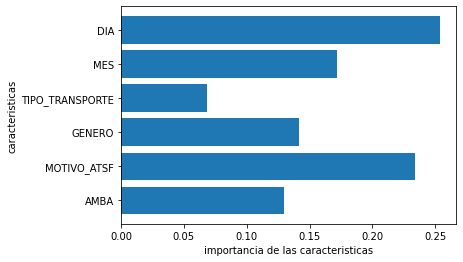

In [ ]:
#graficar resultados de importacia de las distintas columnas
caract=6

plt.barh(range(caract), arbol.feature_importances_)
plt.yticks(np.arange(caract),predictors_label)
plt.xlabel('importancia de las caracteristicas')
plt.ylabel('caracteristicas')
plt.show()

In [ ]:
arbol=DecisionTreeClassifier(max_depth=4)

In [ ]:
#entrenar arbol
arbol.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [ ]:
#precision del test
arbol.score(x_test,y_test)


0.9726027397260274

In [ ]:
#precision del entrenamiento
arbol.score(x_train,y_train)

0.972119258662369

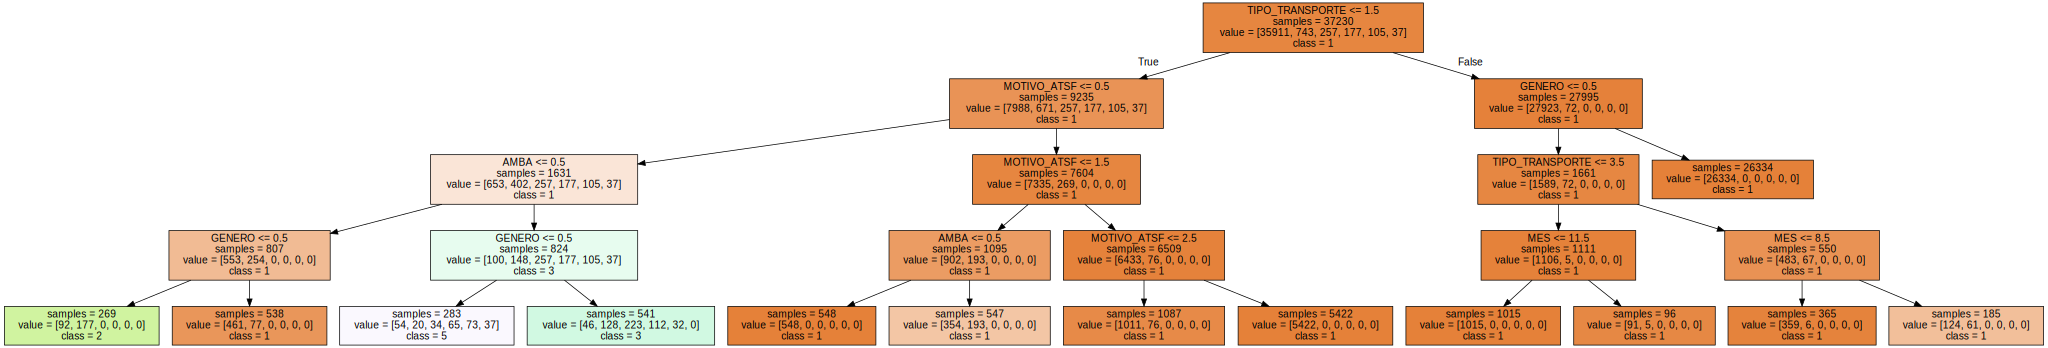

In [ ]:
#graficar arbol profundidad 4
from pydotplus import graph_from_dot_data
export_graphviz(arbol,out_file='arbol.dot', class_names=targerts_label, feature_names=predictors_label,impurity=False, filled=True)

with open('arbol.dot') as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)

In [ ]:
#exportar imagen
dot_data=export_graphviz(arbol,class_names=targerts_label, feature_names=predictors_label)
graph=graph_from_dot_data(dot_data)
graph.write_png('arbol2.png')

True

In [ ]:
sc.stop

In [ ]:
#cerramos la sesion de spark
spark.sparkContext.stop()